<a href="https://colab.research.google.com/github/iyzg/experiments-galore/blob/main/transformer-max.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformer_lens

In [ ]:
!pip install einops

In [ ]:
pip install circuitsvis

In [ ]:
import einops
import torch
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from transformer_lens import HookedTransformer, HookedTransformerConfig, utils
import tqdm.auto as tqdm
import circuitsvis as cv
import itertools
from fancy_einsum import einsum
import transformer_lens.utils as utils

# Introduction

This Colab tackles one of [Neel Nanda's 200 open problems in mechanistic interpretability](https://www.alignmentforum.org/s/yivyHaCAmMJ3CqSyj/p/ejtFsvyhRkMofKAFy), by exploring how a transformer takes the max over a list.

I used a one layer attention-only transformer with a single head and found that its head learns to copy the largest value when at the last position. This is similiar to what the the sorting head discovered by [Bagiński and Kolly](file:///home/felix/Downloads/One%20Attention%20Head%20Is%20All%20You%20Need%20for%20Sorting%20Fixed-Length%20Lists.pdf) (B & K) does when encountering the mid-token (expcept, they are sorting lists in increasing order and hence the mid-token pays attention the lowest value). 

The first few sections deal with setup, data-generation, and model training. Skip to [Interpretability](#scrollTo=D0RLiGYW-ZQK) to read the main analysis.

Somewhat surprisingly, for very short sequence lengths the model learns to also predict the max for subsequences, though this behavior gets less pronounced [for longer sequences](#scrollTo=OvcWD6LgBZy7).

To tell which token is the last in the input sequence the model needs the positional embedding. Hence, when [removing the positional embedding](#scrollTo=wUGXj6S_pP_X), the model always learns to take the max over every subsequence (even for longer input lengths), even if it is only trained to take the max over the whole sequence.

# Hyperparameters

In [ ]:
N_LAYERS = 1
N_HEADS = 1
D_MODEL = 32
D_HEAD = 32
D_MLP = None

D_VOCAB = 64

# Constants

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SEED = 123

In [ ]:
def line(tensor, line_labels=None, yaxis="", xaxis="", **kwargs):
  if isinstance(tensor, torch.Tensor):
    tensor = tensor.detach().numpy()
  labels = {"y":yaxis, "x":xaxis}
  fig = px.line(tensor, labels=labels, **kwargs)
  if line_labels:
      for c, label in enumerate(line_labels):
          fig.data[c].name = label
  fig.show()

# def imshow(tensor, yaxis="", xaxis="", **kwargs):
#   tensor = tensor.detach().numpy()
#   plot_kwargs = {"color_continuous_scale":"RdBu", "color_continuous_midpoint":0.0, "labels":{"x":xaxis, "y":yaxis}}
#   plot_kwargs.update(kwargs)
#   px.imshow(tensor, **plot_kwargs).show()

# Data Generation

Helper functions for generating data and splitting it into batches for training. 

In [ ]:
def generate_data(n_digits=D_VOCAB, sequence_length=2):
  data = list(itertools.product(range(n_digits), repeat=sequence_length))
  data = torch.tensor(data)
  return data

In [ ]:
def shuffle_data(data):
  indices = np.array(range(len(data)))
  np.random.shuffle(indices)
  data = data[indices]
  return data

In [ ]:
def make_generator_from_data(data, batch_size=128):
  """
  Returns a generator that yields slices of length `batch_size` from a list.

  Args:
      data (List[Any]): The input list to be split into batches.
      batch_size (int): The size of each batch.

  Yields:
      List[Any]: A slice of the input list of length `batch_size`. The final slice may be shorter if the
      length of the list is not evenly divisible by `batch_size`.
  """
  data = shuffle_data(data)
  for i in range(0,len(data), batch_size):
    yield data[i:i+batch_size]

In [ ]:
def get_data(
    n_digits=D_VOCAB,
    sequence_length=2,
    training_ratio=0.7):
  """
  Generate a train and test set of tuples containing `sequence_length` integers with values 0 <= n < n_digits.

  Args:
      sequence_length (int): The length of each tuple in the dataset.
      n_digits (int): The number of possible values for each element in the tuple.
      training_ratio (float): The ratio of the size of the training set to the full dataset.

  Returns:
      Tuple[List[Tuple[int, ...]], List[Tuple[int, ...]]]: A tuple containing the training set and test set.
          The training set contains `training_ratio` percent of the full dataset, while the test set contains the
          remaining data. Each set is a list of tuples containing `sequence_length` integers with values 0 <= n < n_digits.
          The tuples have been shuffled before being split into the train and test sets.
  """
  data = generate_data(n_digits=n_digits, sequence_length=sequence_length)

  data = shuffle_data(data)

  split_idx = int(len(data) * training_ratio)
  data_train = data[:split_idx]
  data_test = data[split_idx:]

  return data_train, data_test

In [ ]:
def large_data_gen(n_digits=D_VOCAB, sequence_length=6, batch_size=128, context="train"):
  if context == "train":
    seed = 5
  else:
    seed = 6
  torch.manual_seed(seed)
  while True:
    yield torch.randint(0, n_digits, (batch_size, sequence_length)).to(DEVICE)

# Loss Function

The loss is the cross entropy between the prediction for the final token and the true maximum of the sequence.

In [ ]:
def loss_fn(
    logits, # [batch, pos, d_vocab]
    tokens, # [batch, pos]
    return_per_token=False
  ):
  logits = logits[:, -1, :]
  true_maximum = torch.max(tokens, dim=1)[0]
  log_probs = logits.log_softmax(-1)
  correct_log_probs = log_probs.gather(-1, true_maximum.unsqueeze(-1))
  if return_per_token:
    return -correct_log_probs.squeeze()
  return -correct_log_probs.mean()

In [ ]:
def acc_fn(
    logits, # [batch, pos, d_vocab]
    tokens, # [batch, pos]
    return_per_token=False
  ):
  pred_logits = logits[:, -1, :]
  pred_tokens = torch.argmax(pred_logits, dim=1)
  true_maximum = torch.max(tokens, dim=1)[0]
  if return_per_token:
    return (pred_tokens == true_maximum).float()
  return (pred_tokens == true_maximum).float().mean().item()

Verify that loss is low and accuracy is high for appropriate logits.

In [ ]:
tokens = torch.randint(0, 64, (32, 2))
# tokens = torch.hstack((tokens, torch.max(tokens, dim=1)[0].unsqueeze(-1)))

In [ ]:
logits = torch.rand((32, 2, 64))
logits[list(range(32)),-1,torch.max(tokens, dim=1)[0]] = 10.

In [ ]:
loss_fn(logits, tokens)

tensor(0.0048)

In [ ]:
acc_fn(logits, tokens)

1.0

# Model Setup

A simple one-layer attention only model with a context length of 2.

In [ ]:
cfg = HookedTransformerConfig(
    d_model=D_MODEL,
    n_layers=N_LAYERS,
    n_heads=N_HEADS,
    d_head=D_HEAD,
    n_ctx=2,
    d_vocab=D_VOCAB,
    act_fn="relu",
    seed=SEED,
    device=DEVICE,
    attn_only=True
)
model = HookedTransformer(cfg, move_to_device=True)

In [ ]:
print(model)

HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (pos_embed): PosEmbed()
  (hook_pos_embed): HookPoint()
  (blocks): ModuleList(
    (0): TransformerBlock(
      (ln1): LayerNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (attn): Attention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
      )
      (hook_q_input): HookPoint()
      (hook_k_input): HookPoint()
      (hook_v_input): HookPoint()
      (hook_attn_out): HookPoint()
      (hook_mlp_out): HookPoint()
      (hook_resid_pre): HookPoint()
      (hook_resid_post): HookPoint()
    )
  )
  (ln_final): LayerNorm(
    (hook_scale): HookPoint()
    (hook_normalized): HookPoint()
  )
  (unembed): Unembed()
)


# Training

### Training Loop

We train for 500 epochs with 10 batches of 128 tokens per epoch. (This is somewhat arbitrary as the intention was mostly to get a good model quickly.)

In [ ]:
def train_model(
    model, 
    n_epochs=100,
    batch_size=128,
    batches_per_epoch=10, 
    sequence_length=2
  ):
  lr = 1e-3
  betas = (.9, .999)
  optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=betas)

  train_losses = []

  data_train, data_test = get_data(sequence_length=sequence_length)
  
  for epoch in tqdm.tqdm(range(n_epochs)):
    train_data_gen = make_generator_from_data(data_train, batch_size=batch_size)
    epoch_losses = []
    for _ in range(batches_per_epoch):
      tokens = next(train_data_gen)
      logits = model(tokens)
      losses = loss_fn(logits, tokens, return_per_token=True)
      losses.mean().backward()
      optimizer.step()
      optimizer.zero_grad()
      epoch_losses.extend(losses.detach())
    
    train_losses.append(np.mean(epoch_losses))

    if epoch % 10 == 0:
      print(f'Epoch {epoch} train loss: {train_losses[-1]}')

  model.eval()
  logits = model(data_test)
  acc = acc_fn(logits, data_test)

  print(f"Test accuracy after training: {acc}")

  return train_losses

In [ ]:
train_losses = train_model(model, n_epochs=500, batch_size=128, sequence_length=2)

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0 train loss: 4.379591464996338
Epoch 10 train loss: 1.1837974786758423
Epoch 20 train loss: 0.2676885426044464
Epoch 30 train loss: 0.11423120647668839
Epoch 40 train loss: 0.05837203189730644
Epoch 50 train loss: 0.035729262977838516
Epoch 60 train loss: 0.02775746025145054
Epoch 70 train loss: 0.01914980262517929
Epoch 80 train loss: 0.01275244913995266
Epoch 90 train loss: 0.00990599486976862
Epoch 100 train loss: 0.00795731134712696
Epoch 110 train loss: 0.006372188683599234
Epoch 120 train loss: 0.0055852010846138
Epoch 130 train loss: 0.004725861828774214
Epoch 140 train loss: 0.004123505204916
Epoch 150 train loss: 0.0036488964688032866
Epoch 160 train loss: 0.003114694496616721
Epoch 170 train loss: 0.002598764142021537
Epoch 180 train loss: 0.0023942484986037016
Epoch 190 train loss: 0.0021706284023821354
Epoch 200 train loss: 0.0018792226910591125
Epoch 210 train loss: 0.0017924265703186393
Epoch 220 train loss: 0.0015647809486836195
Epoch 230 train loss: 0.00137861818

As we can see accuracy is high and loss is low.

In [ ]:
line(train_losses, xaxis="Epoch", yaxis="Loss")

# Interpretability

## Attention Patterns

First, we visualize the attention patterns for a few inputs to see if this will give us an idea of what the model is doing.

We begin by getting a batch of data and running a feedforward pass through the model, storing the resulting logits as well as the activations (in cache).

In [ ]:
data_train, data_test = get_data(sequence_length=2)
train_data_gen = make_generator_from_data(data_train, batch_size=128)
tokens = next(train_data_gen)
logits, cache = model.run_with_cache(tokens)

We get the attention pattern from the cache:

In [ ]:
attention_pattern = cache["pattern", 0, "attn"]

Let us now visualize the attention patterns for the first few datapoints:

We see that for sequences (42,22),(20,17), and (33, 21) most of the second tokens attention is on the first token (which has a larger value). On the other hand, for (52, 59) and (1, 13) the second token pays the most attention to itself. This suggests that the head learns to pay more attention to larger tokens for the second position. 

In [ ]:
cv.attention.attention_patterns(tokens=list(map(lambda t: str(t.item()), tokens[0])), attention=attention_pattern[0])

In [ ]:
cv.attention.attention_patterns(tokens=list(map(lambda t: str(t.item()), tokens[1])), attention=attention_pattern[1])

In [ ]:
cv.attention.attention_patterns(tokens=list(map(lambda t: str(t.item()), tokens[2])), attention=attention_pattern[2])

In [ ]:
cv.attention.attention_patterns(tokens=list(map(lambda t: str(t.item()), tokens[4])), attention=attention_pattern[4])

In [ ]:
cv.attention.attention_patterns(tokens=list(map(lambda t: str(t.item()), tokens[5])), attention=attention_pattern[5])

## Visualizing the QK-Circuit

The QK-circuit determines which tokens are attended to by the OV-circuit. By multiplying the embedding of every token with the full QK-Circuit of a particular head, we get a heatmap that shows us the attention every token is paying to every other token for that head. Based on what we have seen we looking at attention patterns we would expect that the QK-circuit of our model's singular head will always be more attentive to tokens with larger values.

Here is are helper functions for visualizing qk-circuits. The function *calculate_qk_attn_heatmap* is mostly based on this [function](https://github.com/MatthewBaggins/one-attention-head-is-all-you-need/blob/main/notebooks/1_Sorting_Fixed_Length_Lists_with_One_Head.ipynb) used by Bagiński and Kolly (B & K). However, I found it necessary to add the positional embedding to get a useful visualization.

In [ ]:
def calculate_qk_attn_heatmap(model, keypos=-1, querypos=-1):
  attn = model.blocks[0].attn
  all_token_embeddings = model.embed(range(D_VOCAB))
  positional_embeddings = model.pos_embed(all_token_embeddings)
 
  token_embeddings_at_keypos = all_token_embeddings + positional_embeddings[:,keypos,:] if keypos > -1 else all_token_embeddings
  token_embeddings_at_querypos = all_token_embeddings + positional_embeddings[:,querypos,:] if querypos > -1 else all_token_embeddings

  embeddings_key = einsum("d_vocab d_model, n_heads d_model d_head -> n_heads d_vocab d_head", 
                          token_embeddings_at_keypos, attn.W_K) 
  embeddings_query = einsum("d_vocab d_model, n_heads d_model d_head -> n_heads d_vocab d_head", 
                            token_embeddings_at_querypos, attn.W_Q) 
                            
  plt.rcParams['figure.figsize'] = [20, 10]
  qk_circuit_attn_heatmap = einsum(
      "n_heads d_vocab_q d_head, n_heads d_vocab_k d_head -> ... d_vocab_q d_vocab_k", 
      embeddings_query, embeddings_key
      ).detach().cpu().numpy()

  return qk_circuit_attn_heatmap

def plot_qk_heatmap(model, keypos=-1, querypos=-1):
  qk_attn_heatmap = calculate_qk_attn_heatmap(model, keypos=keypos, querypos=querypos)

  fig, ax = plt.subplots(figsize=(8, 8))
  graph = ax.imshow(qk_attn_heatmap, cmap="hot", interpolation="nearest")
  plt.colorbar(graph)
  plt.tight_layout()

def plot_avg_qk_heatmap(model, keypositions, querypos=-1):
  heatmaps = []
  
  for keypos in keypositions:
    heatmaps.append(calculate_qk_attn_heatmap(model, keypos=keypos, querypos=querypos))

  qk_circuit_attn_heatmap = np.mean(heatmaps, axis=0)

  fig, ax = plt.subplots(figsize=(8, 8))
  graph = ax.imshow(qk_circuit_attn_heatmap, cmap="hot", interpolation="nearest")
  plt.colorbar(graph)
  plt.tight_layout()

Let us look at what the full QK-circuit does in our model. In the below heatmap values at point (x,y) show how much attention is paid to token x from token y. 

As you can see this map looks quite random. This is probably because, unlike in B&K's work, it is only the position and not the value of the token which is important for attention. At second position, more attention should always be paid to higher token valus, regardless of the exact value of the token.

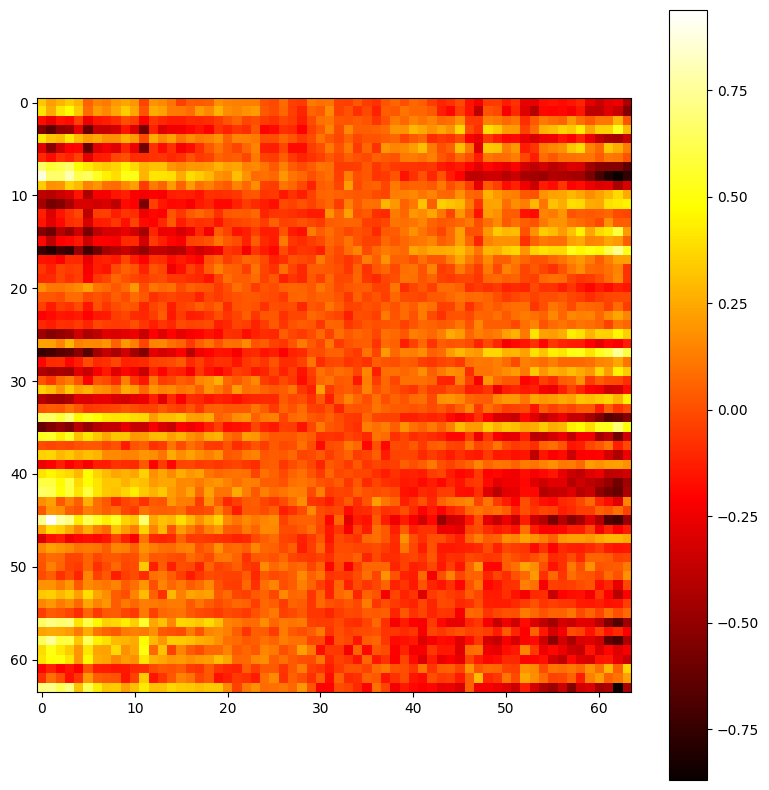

In [ ]:
plot_qk_heatmap(model)

With this insight, let us draw new heatmaps showing the attention paid by tokens at position to tokens at position 0 and 1. These look like what we might expect, with higher values getting more attention.

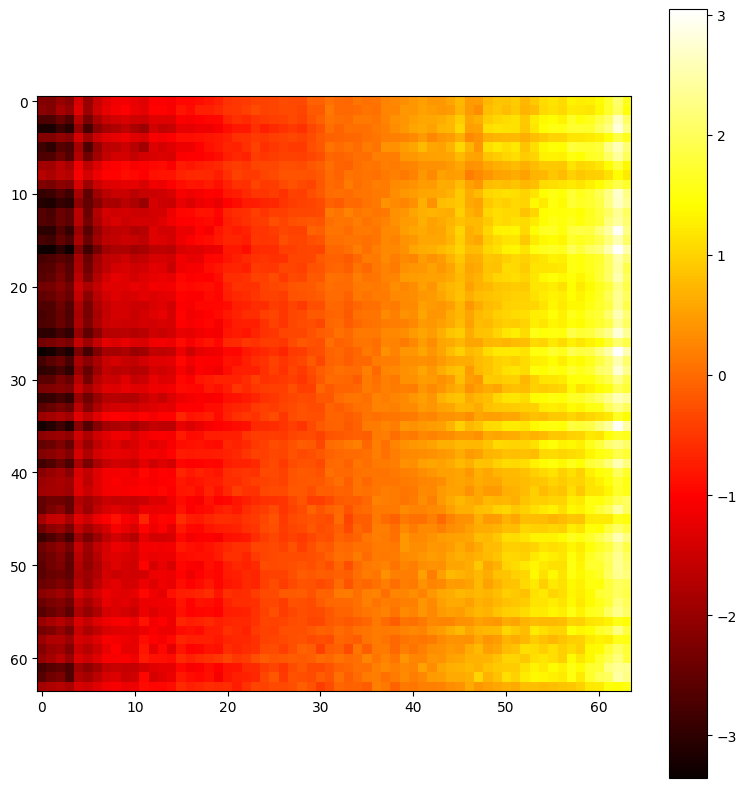

In [ ]:
plot_qk_heatmap(model, keypos=0, querypos=1)

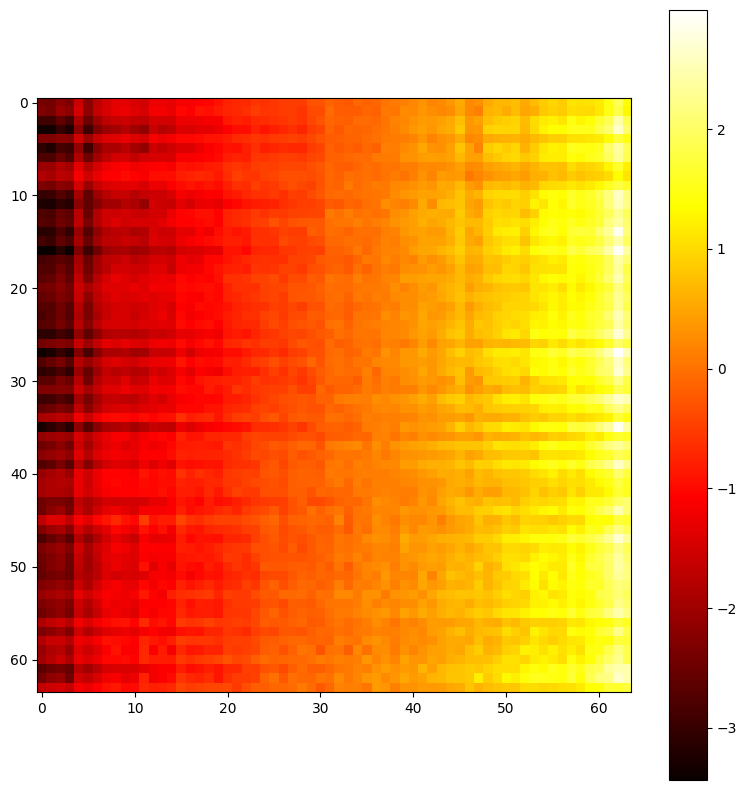

In [ ]:
plot_qk_heatmap(model, keypos=1, querypos=1)

Somewhat surprisingly, the heatmap still looks the same for two tokens that are both at position 0. Perhaps, it was easiest to learn key- and value-embeddings that always map higher values to higher attention for any position.

If we assume that the OV-circuit is copying (see analysis below), then this could suggest:
- the model's prediction for the second token will always be the first token.
- for models that are trained to take the maximum of longer sequences, their prediction after a subsequence will be the maximum of that subsequence.

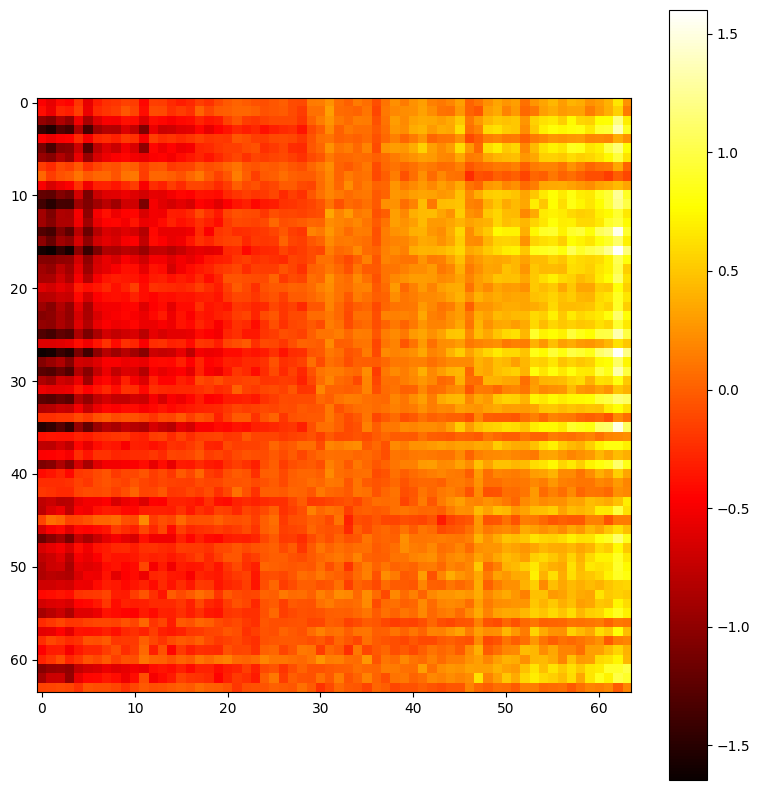

In [ ]:
plot_qk_heatmap(model, keypos=0, querypos=0)

Let us test the first hypothesis!
First I will create some new data and let the model predict the logits:

In [ ]:
data_train, data_test = get_data(sequence_length=2)
train_data_gen = make_generator_from_data(data_train, batch_size=128)
tokens = next(train_data_gen)
logits = model(tokens)

Now let us check how often the model predicts that the second token will be the same as the first. This code takes the index of the highest logit from the model predictions for the second token and compares it to the first token. Then it divides how often the two coincide by the batch size to get an accuracy score.  

In [ ]:
torch.sum((torch.argmax(logits, dim=2)[:,0] == tokens[:,0]).float()).item() / 128

1.0

As we can see the model almost always predicts the second token to be equal to the first in this batch!

## Analyzing the OV-Circuit

After the QK-Circuit determines which tokens will be attended to by a head, the OV-Circuit determines the computations that are applied to those tokens. In the above section we saw that the QK-Circuit will attend to the highest token in the sequence. As our model is doing the max operation, this means we can expect that OV-circuit's job will be to "copy" that token, by increasing the logits of the corresponding token.

I will be using two metrics to verify if the circuit is copying: 

Firstly, plotting a heatmap of token attentions should display a clearly visible diagonal line, with values along the diagonal being higher than elsewhere. This means that a tokens increases its own logits.  

Another way of detecting a copying circuit is by [looking at the fraction of the circuit's eigenvalues](https://transformer-circuits.pub/2021/framework/index.html#summarizing-ovqk-matrices) that are positive. 

Below are helper function for those metrics:

In [ ]:
def plot_ov_heatmap(model, pos=-1):
  attn = model.blocks[0].attn
  all_token_embeddings = model.embed(range(D_VOCAB))

  token_embeddings_at_pos = all_token_embeddings + model.pos_embed(all_token_embeddings)[:,pos,:] if pos > -1 else all_token_embeddings

  embeddings_value = einsum("d_vocab d_model, n_heads d_model d_head -> n_heads d_vocab d_head", 
                          token_embeddings_at_pos, attn.W_V)
  
  embeddings_out = einsum("n_heads d_vocab d_model1, n_heads d_model1 d_model2 -> n_heads d_vocab d_model2",
                        embeddings_value, attn.W_O)
  
  ov_circuit_attn_heatmap = model.unembed(embeddings_out).detach()

  fig, ax = plt.subplots(figsize=(8, 8))
  graph = ax.imshow(ov_circuit_attn_heatmap[0], cmap="hot", interpolation="nearest")
  plt.colorbar(graph)
  plt.tight_layout()

In [ ]:
def get_full_ov_copying_score(model):
  full_OV_circuit = model.embed.W_E @ model.OV @ model.unembed.W_U
  full_OV_circuit_eigenvalues = full_OV_circuit.eigenvalues
  full_OV_copying_score = full_OV_circuit_eigenvalues.sum(dim=-1).real / full_OV_circuit_eigenvalues.abs().sum(dim=-1)
  return full_OV_copying_score.detach().item()

As we can see, the heatmap looks as we expected, confirming our predicting about how the model works:

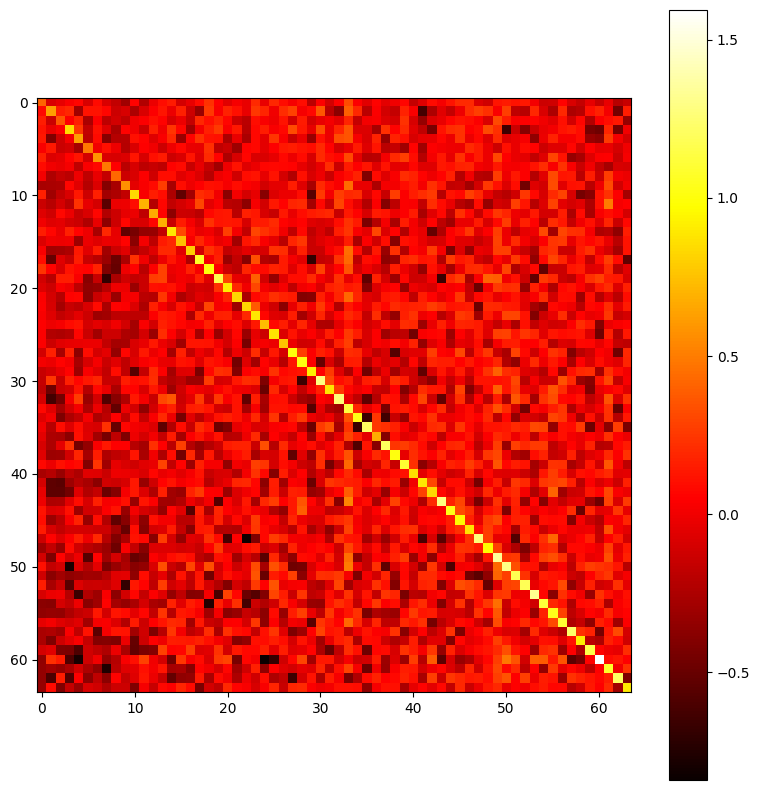

In [ ]:
plot_ov_heatmap(model, pos=1)

The OV copying score is also very high:

In [ ]:
get_full_ov_copying_score(model)

0.9994037747383118

# Exploring Longer Sequences

In this section I train two more models to take the max of sequences of lenght 3 and 6. This is to verify that they are using the same algorithm as the previous model, and the test the earlier hypothesis that models for larger sequences would also learn to predict the max of subsequences. 

### Training New Models

In [ ]:
cfg_3t = HookedTransformerConfig(
    d_model=D_MODEL,
    n_layers=N_LAYERS,
    n_heads=N_HEADS,
    d_head=D_HEAD,
    n_ctx=3,
    d_vocab=D_VOCAB,
    act_fn="relu",
    seed=SEED,
    device=DEVICE,
    attn_only=True
)
model_3t = HookedTransformer(cfg_3t, move_to_device=True)

In [ ]:
train_losses = train_model(model_3t, n_epochs=1000, batch_size=128, sequence_length=3)

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 0 train loss: 4.179675579071045
Epoch 10 train loss: 1.2281990051269531
Epoch 20 train loss: 0.3443881869316101
Epoch 30 train loss: 0.1750771701335907
Epoch 40 train loss: 0.09808535873889923
Epoch 50 train loss: 0.07751448452472687
Epoch 60 train loss: 0.04538407176733017
Epoch 70 train loss: 0.03786114230751991
Epoch 80 train loss: 0.02956446073949337
Epoch 90 train loss: 0.025329027324914932
Epoch 100 train loss: 0.019254067912697792
Epoch 110 train loss: 0.01948763057589531
Epoch 120 train loss: 0.009693050757050514
Epoch 130 train loss: 0.01620636321604252
Epoch 140 train loss: 0.01688654161989689
Epoch 150 train loss: 0.01429685764014721
Epoch 160 train loss: 0.010954312980175018
Epoch 170 train loss: 0.015721051022410393
Epoch 180 train loss: 0.011952104046940804
Epoch 190 train loss: 0.010334208607673645
Epoch 200 train loss: 0.005895194131880999
Epoch 210 train loss: 0.005908380728214979
Epoch 220 train loss: 0.008639581501483917
Epoch 230 train loss: 0.0036597871221601

In [ ]:
line(train_losses, xaxis="Epoch", yaxis="Loss")

In [ ]:
cfg_6t = HookedTransformerConfig(
    d_model=D_MODEL,
    n_layers=N_LAYERS,
    n_heads=N_HEADS,
    d_head=D_HEAD,
    n_ctx=6,
    d_vocab=D_VOCAB,
    act_fn="relu",
    seed=SEED,
    device=DEVICE,
    attn_only=True
)
model_6t = HookedTransformer(cfg_6t, move_to_device=True)

In [ ]:
def train_model_for_large_sequence_length(
    model, 
    n_epochs=100,
    batch_size=128,
    batches_per_epoch=10, 
    sequence_length=2
  ):
  lr = 1e-3
  betas = (.9, .999)
  optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=betas)

  train_losses = []

  train_data_gen = large_data_gen(n_digits=D_VOCAB, sequence_length=sequence_length, batch_size=batch_size, context="train")
  
  for epoch in tqdm.tqdm(range(n_epochs)):
    epoch_losses = []
    for _ in range(batches_per_epoch):
      tokens = next(train_data_gen)
      logits = model(tokens)
      losses = loss_fn(logits, tokens, return_per_token=True)
      losses.mean().backward()
      optimizer.step()
      optimizer.zero_grad()
      epoch_losses.extend(losses.detach())
    
    train_losses.append(np.mean(epoch_losses))

    if epoch % 10 == 0:
      print(f'Epoch {epoch} train loss: {train_losses[-1]}')

  model.eval()
  test_data_gen = large_data_gen(n_digits=D_VOCAB, sequence_length=sequence_length, batch_size=batch_size * 20, context="test")
  data_test = next(test_data_gen)
  logits = model(data_test)
  acc = acc_fn(logits, data_test)

  print(f"Test accuracy after training: {acc}")

  return train_losses

In [ ]:
train_losses = train_model_for_large_sequence_length(model_6t, n_epochs=1000, batch_size=128, sequence_length=6)

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 0 train loss: 4.423232555389404
Epoch 10 train loss: 1.4284833669662476
Epoch 20 train loss: 0.29326891899108887
Epoch 30 train loss: 0.13953189551830292
Epoch 40 train loss: 0.12275437265634537
Epoch 50 train loss: 0.07188280671834946
Epoch 60 train loss: 0.049911294132471085
Epoch 70 train loss: 0.03298039734363556
Epoch 80 train loss: 0.032226383686065674
Epoch 90 train loss: 0.026979763060808182
Epoch 100 train loss: 0.027612393721938133
Epoch 110 train loss: 0.019736485555768013
Epoch 120 train loss: 0.017476361244916916
Epoch 130 train loss: 0.017545118927955627
Epoch 140 train loss: 0.014851960353553295
Epoch 150 train loss: 0.00961834192276001
Epoch 160 train loss: 0.015466993674635887
Epoch 170 train loss: 0.0076986015774309635
Epoch 180 train loss: 0.004281903151422739
Epoch 190 train loss: 0.01481338869780302
Epoch 200 train loss: 0.018754225224256516
Epoch 210 train loss: 0.008751481771469116
Epoch 220 train loss: 0.006905979011207819
Epoch 230 train loss: 0.004355175

In [ ]:
line(train_losses, xaxis="Epoch", yaxis="Loss")

## Sequence Length 3

### Attention Patterns

The patterns we see here fit with out predictions. Tokens at every position attend to the highest value token.

In [ ]:
data_train, data_test = get_data(sequence_length=3)
train_data_gen = make_generator_from_data(data_train, batch_size=128)
tokens = next(train_data_gen)
logits, cache = model_3t.run_with_cache(tokens)
print("Loss:", loss_fn(logits, tokens).item())

Loss: 6.792297790525481e-05


In [ ]:
attention_pattern = cache["pattern", 0, "attn"]

In [ ]:
cv.attention.attention_patterns(tokens=list(map(lambda t: str(t.item()), tokens[0])), attention=attention_pattern[0])

In [ ]:
cv.attention.attention_patterns(tokens=list(map(lambda t: str(t.item()), tokens[1])), attention=attention_pattern[1])

In [ ]:
cv.attention.attention_patterns(tokens=list(map(lambda t: str(t.item()), tokens[2])), attention=attention_pattern[2])

In [ ]:
cv.attention.attention_patterns(tokens=list(map(lambda t: str(t.item()), tokens[3])), attention=attention_pattern[3])

### Circuit Analysis

As there more positional encoding now we plot the average over all key positions for a given query position.

We see a similar pattern as with the previous model at every position. However, it seems to be slightly less pronounced for earlier positions. This suggest that we might see an even weaker effect when investigating the model for sequences of lenght 6 later.

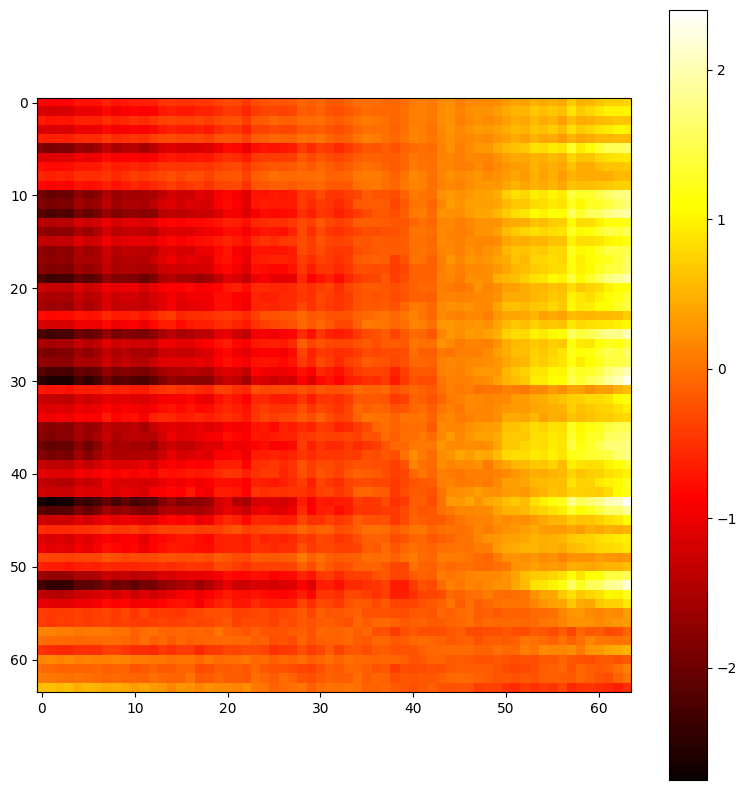

In [ ]:
plot_avg_qk_heatmap(model_3t, list(range(3)), querypos=0)

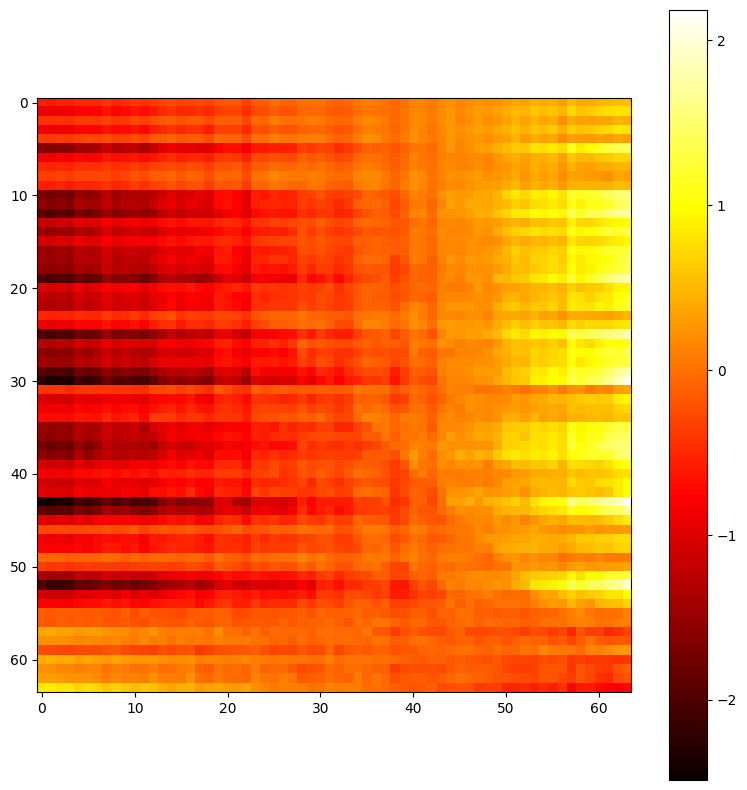

In [ ]:
plot_avg_qk_heatmap(model_3t, list(range(3)), querypos=1)

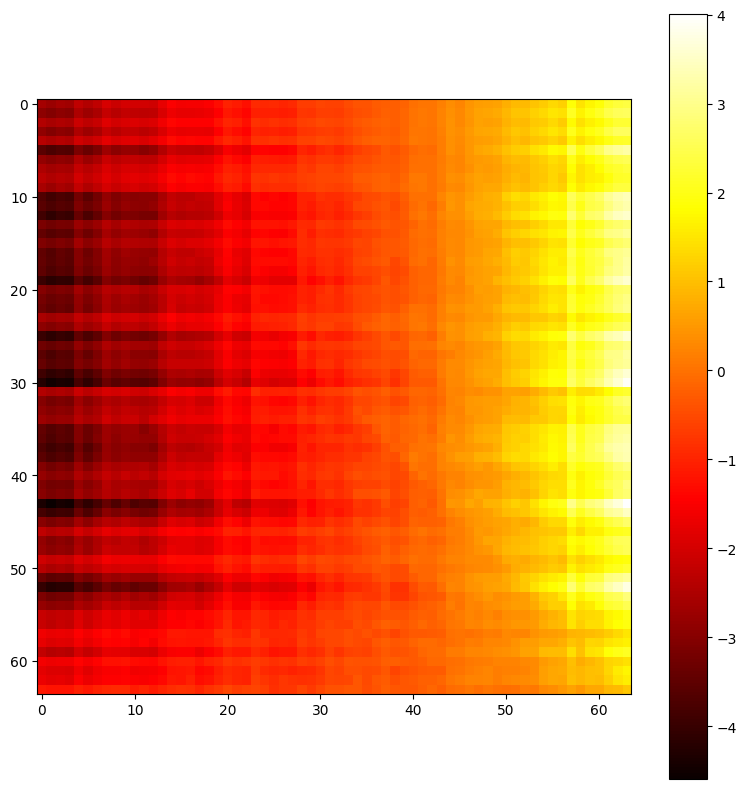

In [ ]:
plot_avg_qk_heatmap(model_3t, list(range(3)), querypos=2)

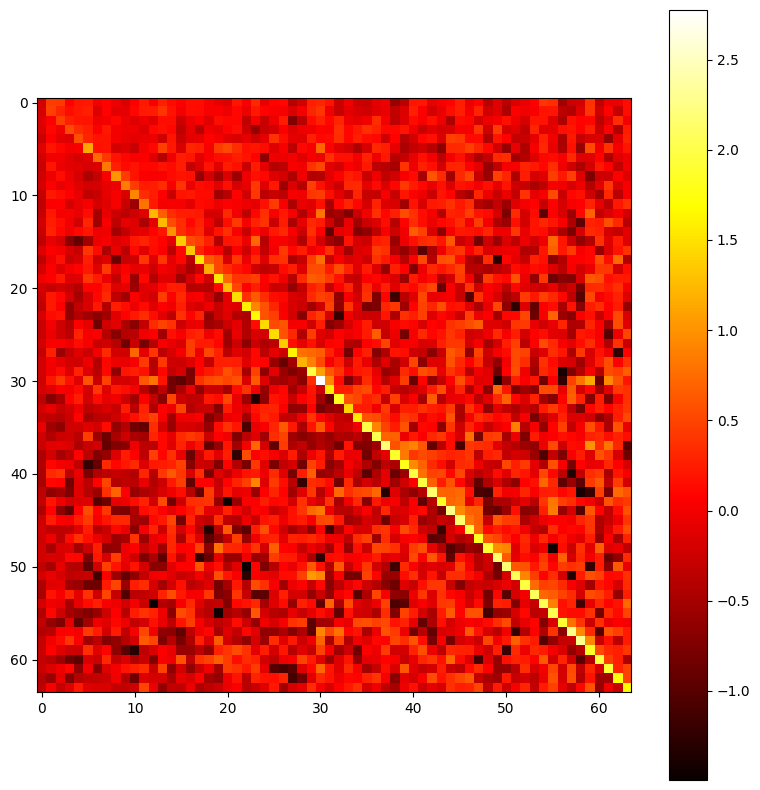

In [ ]:
plot_ov_heatmap(model_3t, pos=0)

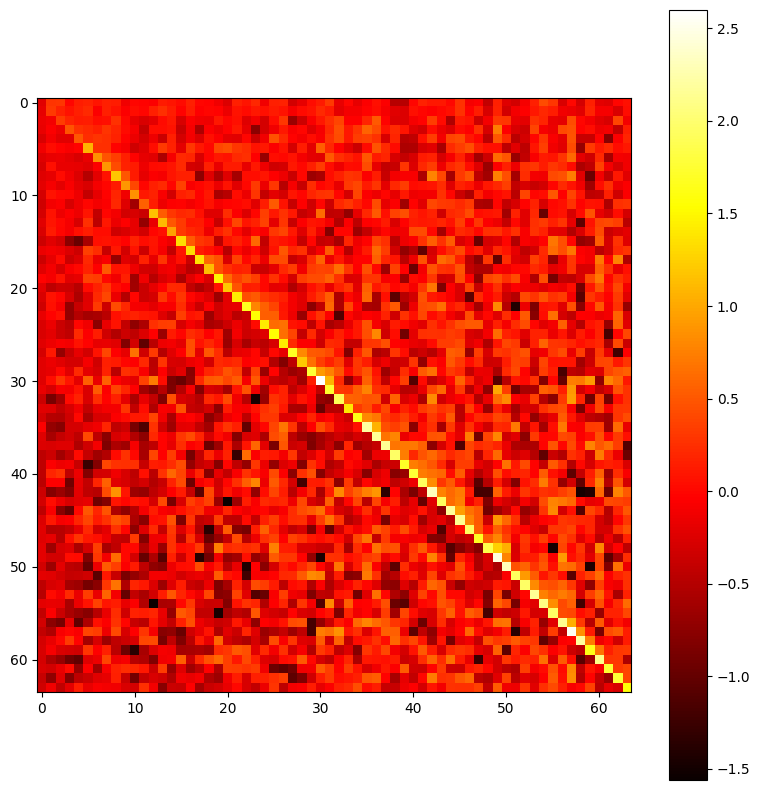

In [ ]:
plot_ov_heatmap(model_3t, pos=1)

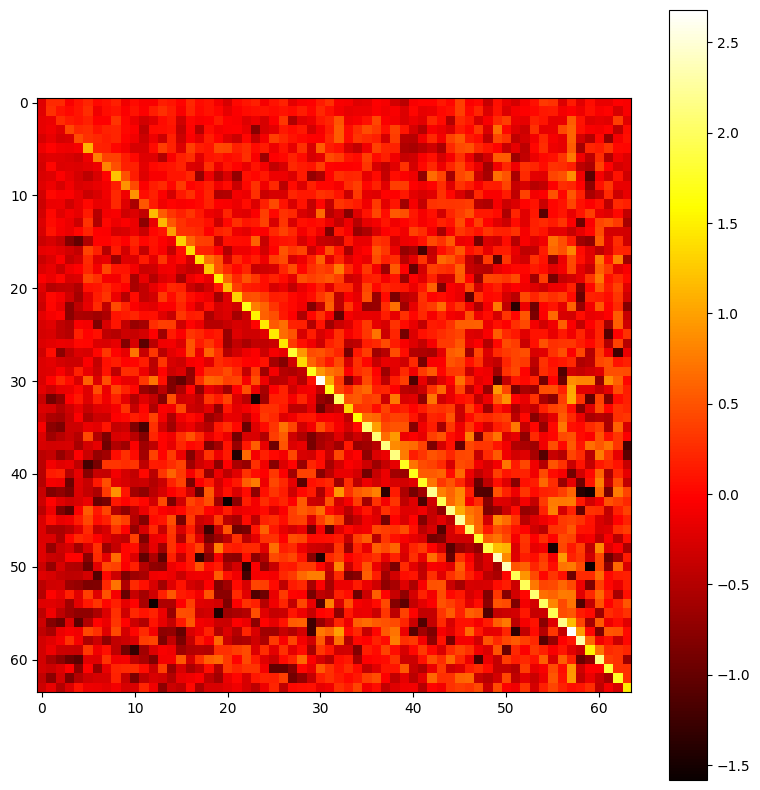

In [ ]:
plot_ov_heatmap(model_3t, pos=2)

### Evaluating Subsequence Accuracy

Here I test the hypothesis that the model also learns to take the max of subsequences (with which I mean a sequences starting at position 0 and endind somewhwere before the sequence length). We already saw that for sequence lenght 2, the model predicts the second element to be the same as the first which can be seen as taking the max over the subsequence of length 1. As the model I am investigating here takes sequences of lenght 3, I can now also look at the model's prediction for subsequences of length 2:

In [ ]:
data_train, data_test = get_data(sequence_length=3)
train_data_gen = make_generator_from_data(data_train, batch_size=128)
tokens = next(train_data_gen)
logits = model_3t(tokens)

The following function evaluates the accuracy of predictions for subsequences:

In [ ]:
def subsequence_accuracy(logits, tokens, ss_length, batch_size=128):
  correct_preds = torch.sum((torch.argmax(logits, dim=2)[:,ss_length] == torch.max(tokens[:,:ss_length+1], dim=1)[0]).float()).item()
  return correct_preds / batch_size 

As before, the model always predicts the first and second token to be same:

In [ ]:
subsequence_accuracy(logits, tokens, 0)

1.0

It also achieves a reasonably high accuracy of 92% on the task of predict the max on the subsequence of length 2, though this is noticeably lower than the accuracy for taking the max over the whole sequence:

In [ ]:
subsequence_accuracy(logits, tokens, 1)

0.890625

## Sequence Length 6


### Attention Pattern

From the example attention patterns, it does not look like the model is still learning to take the subsequence maximum.

In [ ]:
tokens = next(large_data_gen())
logits, cache = model_6t.run_with_cache(tokens)

In [ ]:
attention_pattern = cache["pattern", 0, "attn"]

In [ ]:
cv.attention.attention_patterns(tokens=list(map(lambda t: str(t.item()), tokens[0])), attention=attention_pattern[0])

In [ ]:
cv.attention.attention_patterns(tokens=list(map(lambda t: str(t.item()), tokens[1])), attention=attention_pattern[1])

In [ ]:
cv.attention.attention_patterns(tokens=list(map(lambda t: str(t.item()), tokens[2])), attention=attention_pattern[2])

In [ ]:
cv.attention.attention_patterns(tokens=list(map(lambda t: str(t.item()), tokens[3])), attention=attention_pattern[3])

### Circuit Analysis

For the QK circuits, we see that only the attention from position 6 (index 5) looks as before. For most other positions the pattern looks random, and for position 5 (index 4) it is looks like lower tokens are getting higher attention! In the next section we will see that the model gets very low accuracy for taking the max of subsequences up to position 5, which is what we would expect from this attention pattern.  

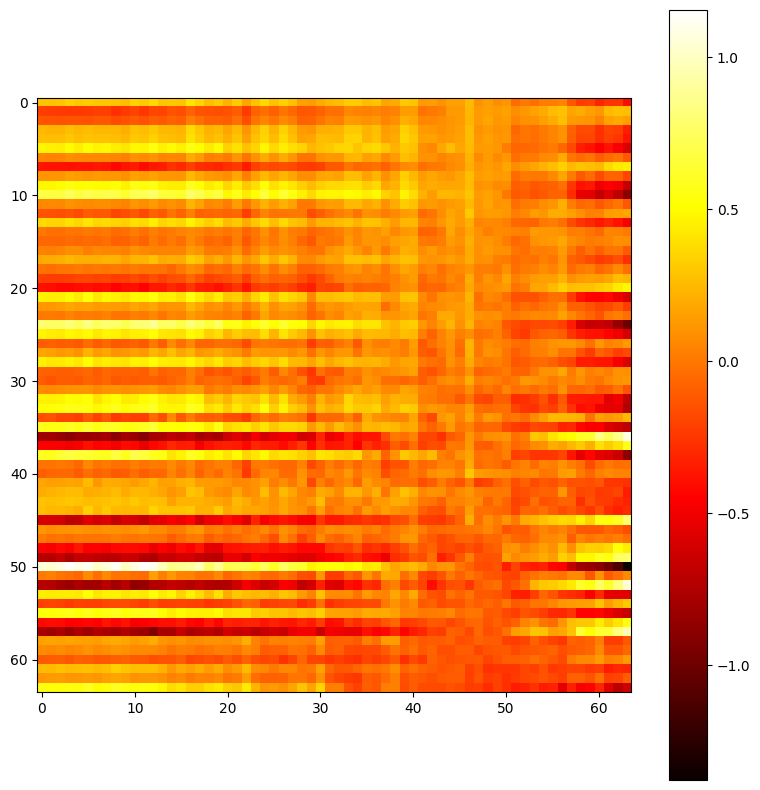

In [ ]:
plot_avg_qk_heatmap(model_6t, list(range(6)), querypos=0)

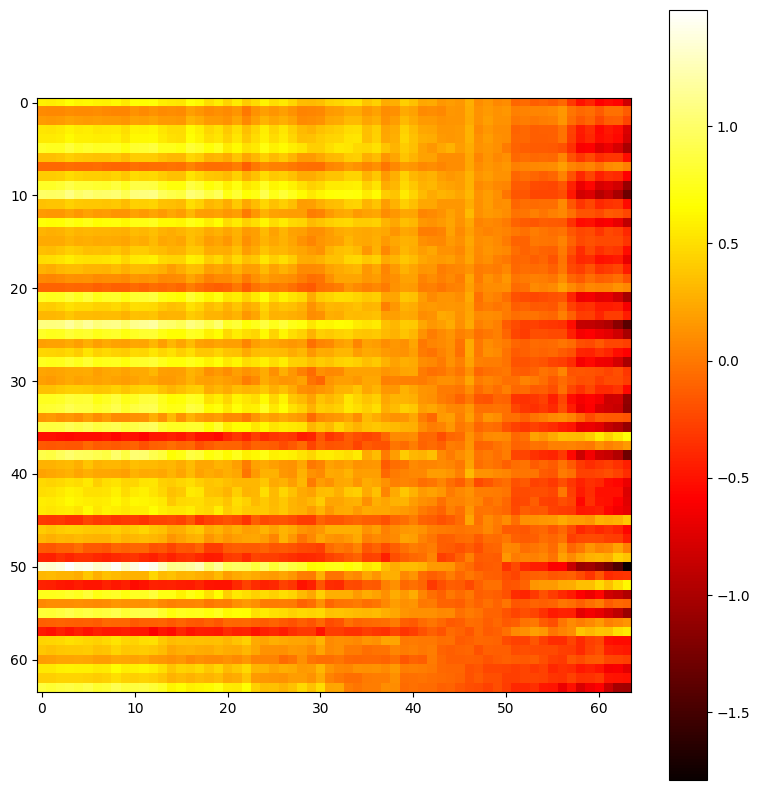

In [ ]:
plot_avg_qk_heatmap(model_6t, list(range(6)), querypos=1)

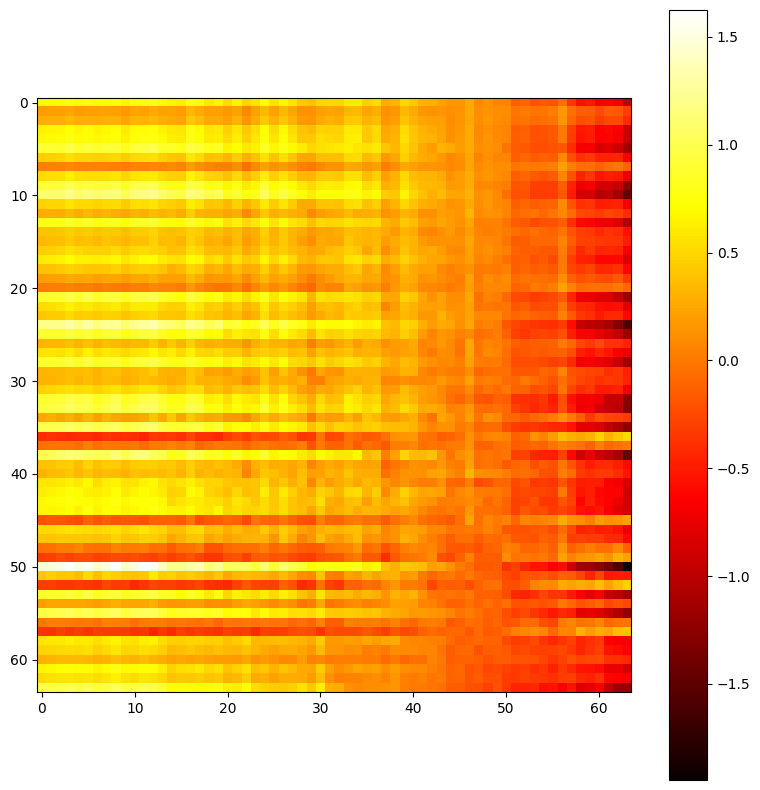

In [ ]:
plot_avg_qk_heatmap(model_6t, list(range(6)), querypos=2)

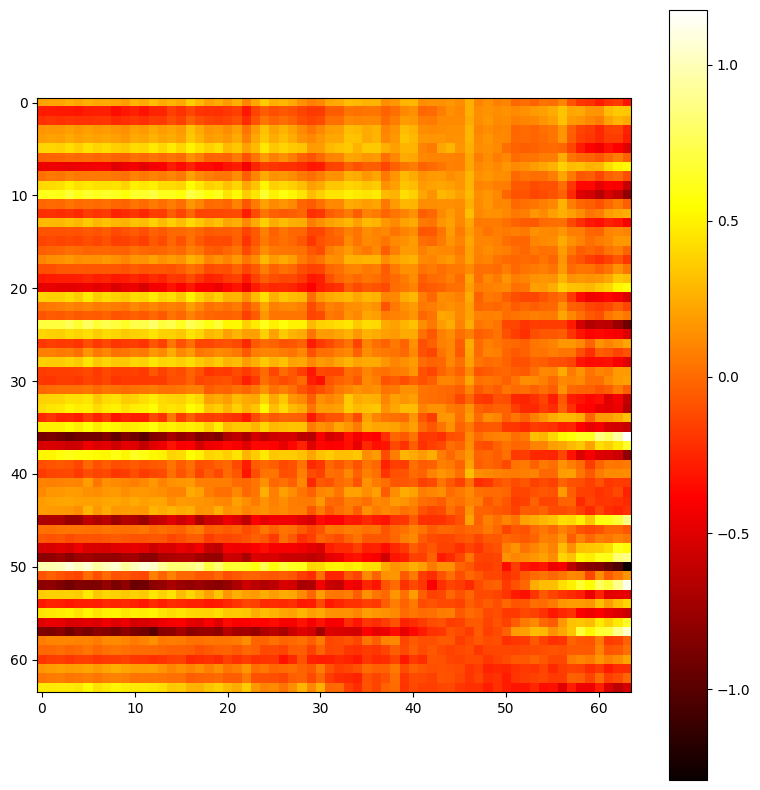

In [ ]:
plot_avg_qk_heatmap(model_6t, list(range(6)), querypos=3)

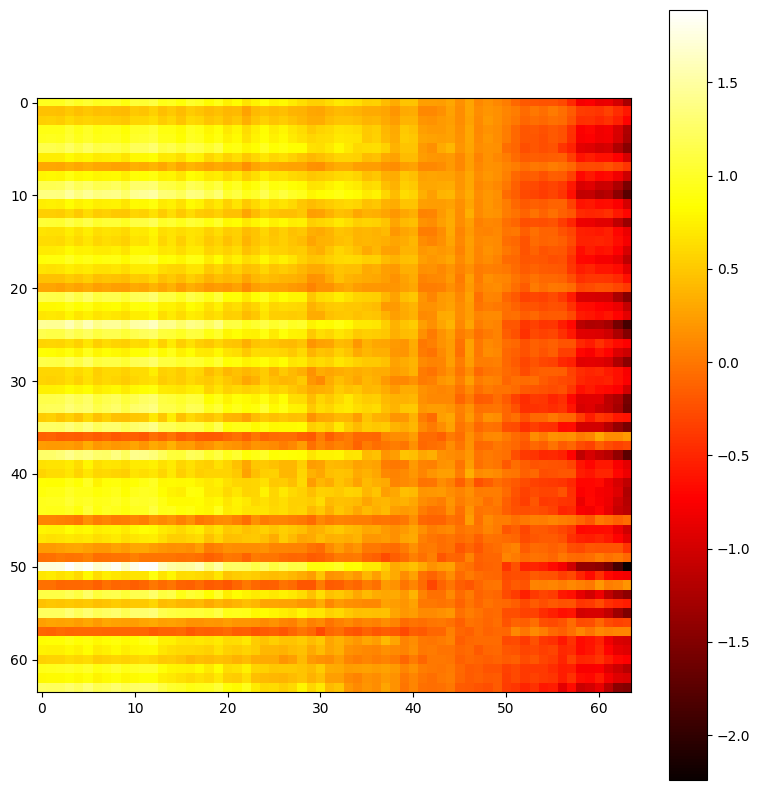

In [ ]:
plot_avg_qk_heatmap(model_6t, list(range(6)), querypos=4)

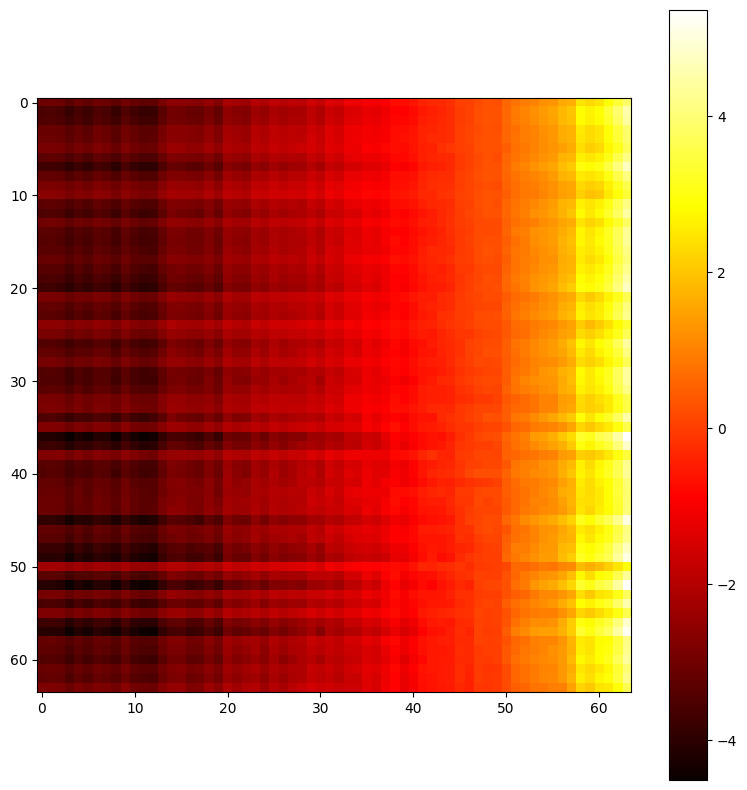

In [ ]:
plot_avg_qk_heatmap(model_6t, list(range(6)), querypos=5)

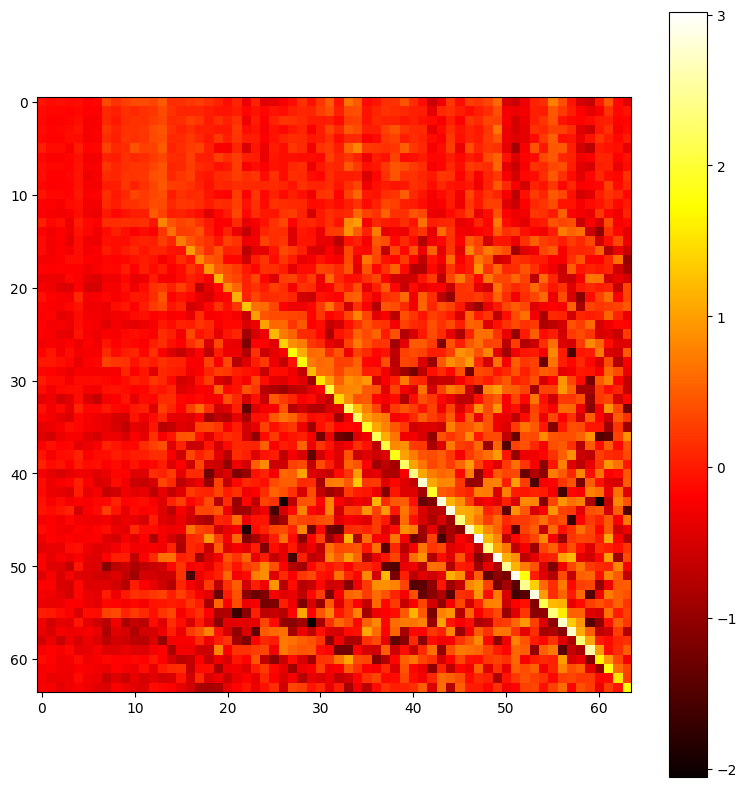

In [ ]:
plot_ov_heatmap(model_6t, pos=0)

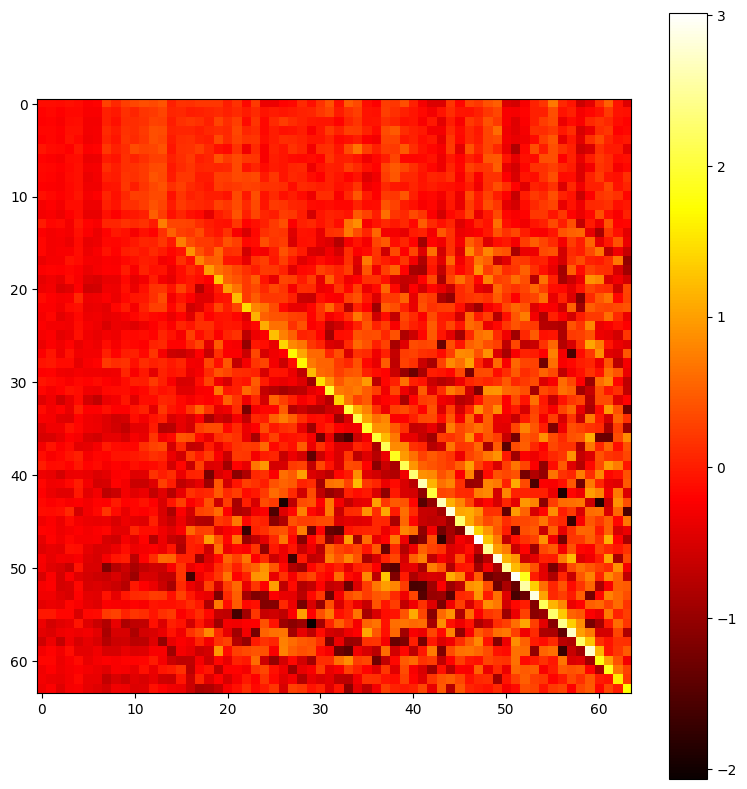

In [ ]:
plot_ov_heatmap(model_6t, pos=1)

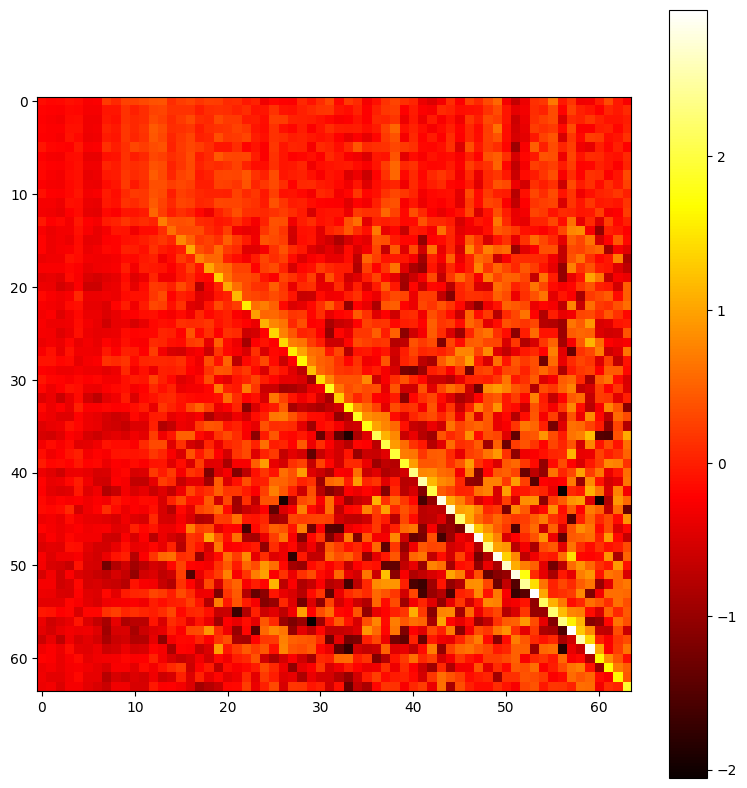

In [ ]:
plot_ov_heatmap(model_6t, pos=2)

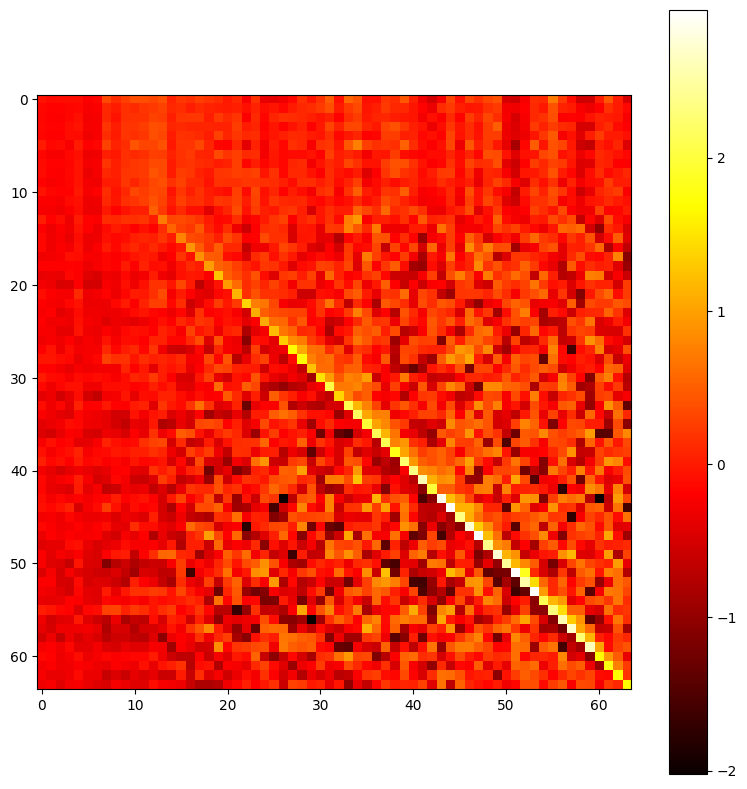

In [ ]:
plot_ov_heatmap(model_6t, pos=3)

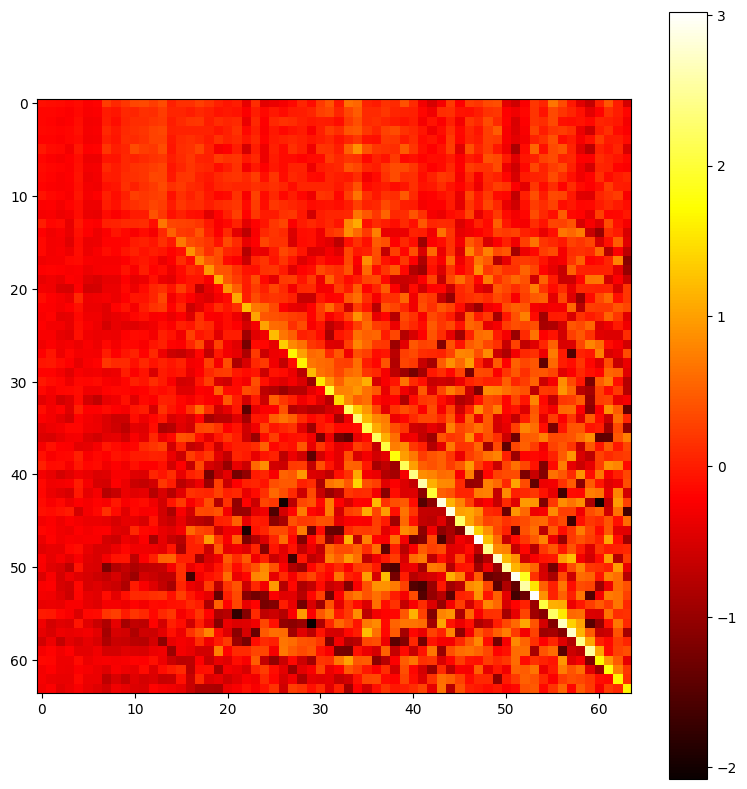

In [ ]:
plot_ov_heatmap(model_6t, pos=4)

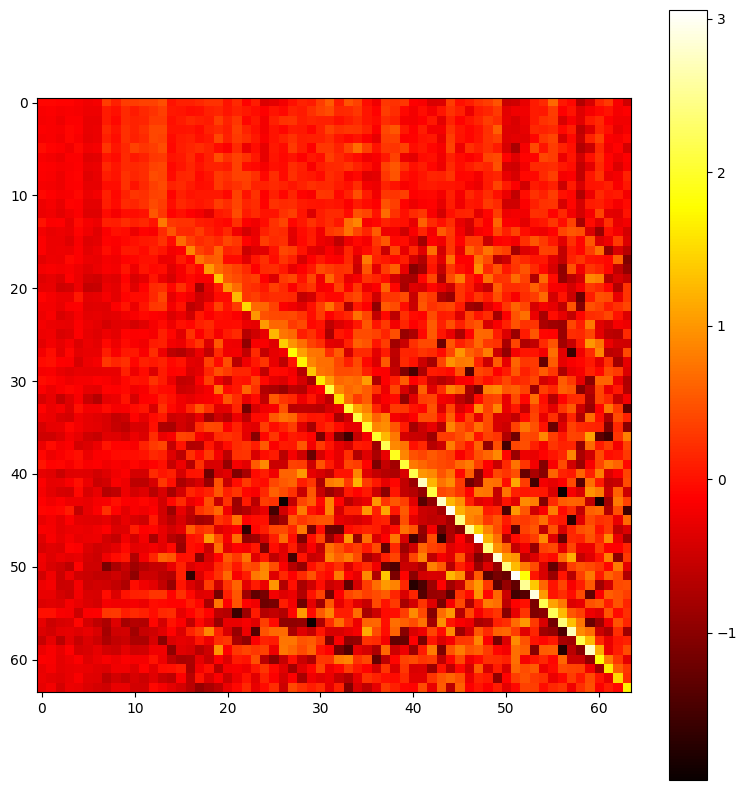

In [ ]:
plot_ov_heatmap(model_6t, pos=5)

### Evaluating Subsequence Accuracy

The following bar plot shows the accuracy for predicting the max of a subsequence of lenght n. It confirms the suspicion of our circuit analysis, that the model's capabilities did not generalize to subsequences.

In [ ]:
ss_accuracies = [subsequence_accuracy(logits, tokens, i) for i in range(6)]

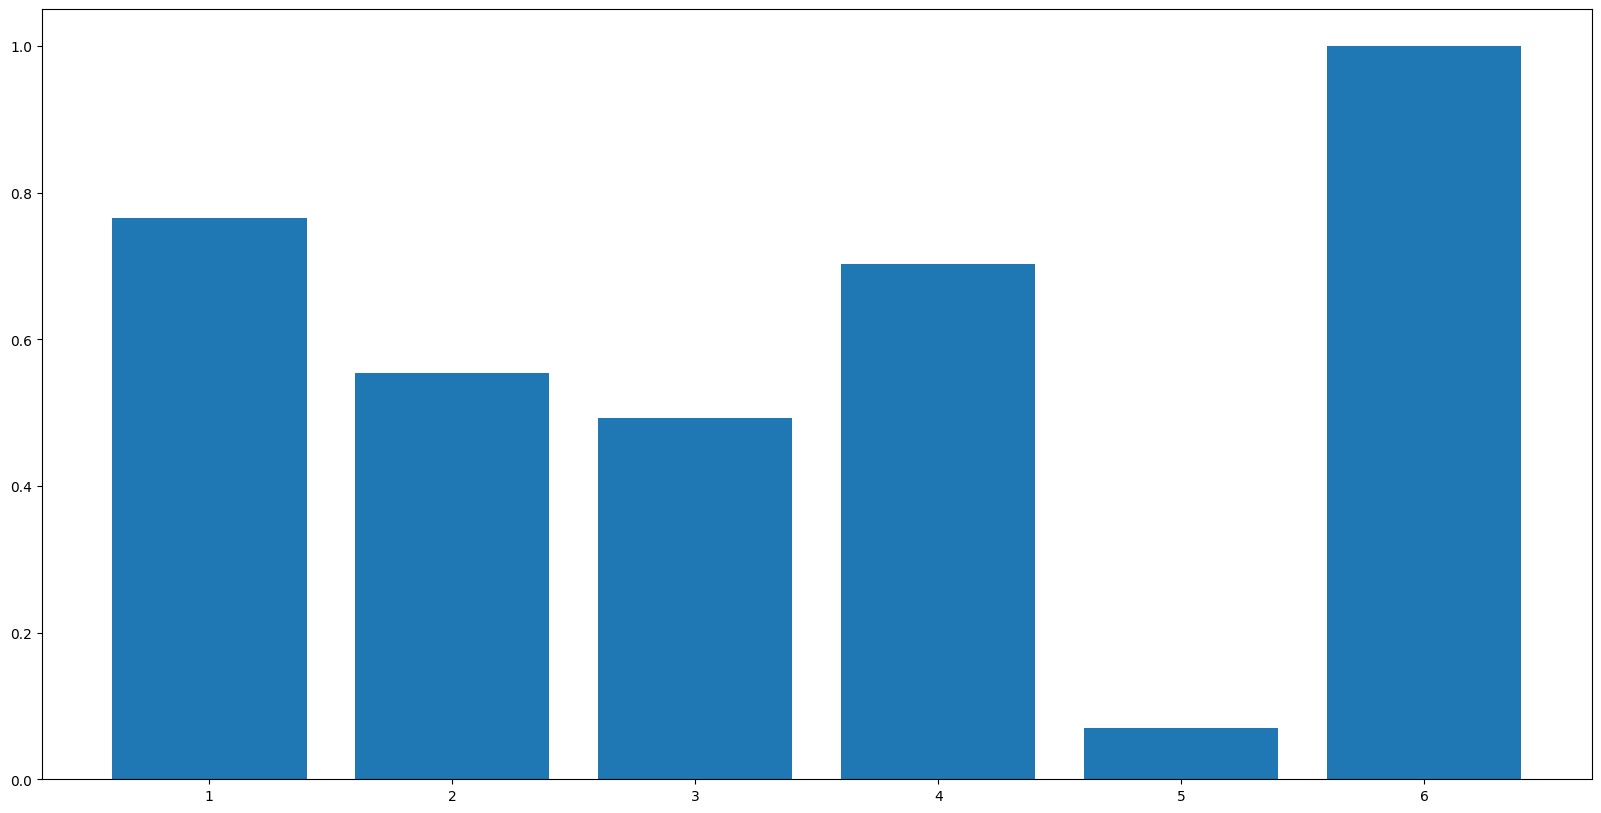

In [ ]:
plt.bar(list(range(1,7)), ss_accuracies, align='center')
plt.show()

# Removing The Positional Embedding

## Training a model for sequences of length 6 with no positional embedding

In [ ]:
def deactivate_position(model):
    model.pos_embed.W_pos.data[:] = 0.
    model.pos_embed.W_pos.requires_grad = False

In [ ]:
cfg_6t_no_pos = HookedTransformerConfig(
    d_model=D_MODEL,
    n_layers=N_LAYERS,
    n_heads=N_HEADS,
    d_head=D_HEAD,
    n_ctx=6,
    d_vocab=D_VOCAB,
    act_fn="relu",
    seed=SEED,
    device=DEVICE,
    attn_only=True
)
model_6t_no_pos = HookedTransformer(cfg_6t_no_pos, move_to_device=True)
deactivate_position(model_6t_no_pos)

In [ ]:
train_losses = train_model_for_large_sequence_length(model_6t_no_pos, n_epochs=1000, batch_size=128, sequence_length=6)

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 0 train loss: 4.289209842681885
Epoch 10 train loss: 1.7798776626586914
Epoch 20 train loss: 0.3008168339729309
Epoch 30 train loss: 0.12973707914352417
Epoch 40 train loss: 0.10386264324188232
Epoch 50 train loss: 0.04492169991135597
Epoch 60 train loss: 0.036399971693754196
Epoch 70 train loss: 0.0256730318069458
Epoch 80 train loss: 0.0249604731798172
Epoch 90 train loss: 0.01903076097369194
Epoch 100 train loss: 0.023540819063782692
Epoch 110 train loss: 0.011128711514174938
Epoch 120 train loss: 0.017265846952795982
Epoch 130 train loss: 0.017691876739263535
Epoch 140 train loss: 0.014856499619781971
Epoch 150 train loss: 0.008630519732832909
Epoch 160 train loss: 0.010335355065762997
Epoch 170 train loss: 0.006857105530798435
Epoch 180 train loss: 0.009094085544347763
Epoch 190 train loss: 0.004589980002492666
Epoch 200 train loss: 0.0073235854506492615
Epoch 210 train loss: 0.0024975836277008057
Epoch 220 train loss: 0.006144397892057896
Epoch 230 train loss: 0.00486244400

In [ ]:
line(train_losses, xaxis="Epoch", yaxis="Loss")

## QK Circuit Without Positional Embedding

As we can see, the QK heatmap is now interpretable without the positional embedding. Once again we see that more attention is paid to tokens of higher cardinality.

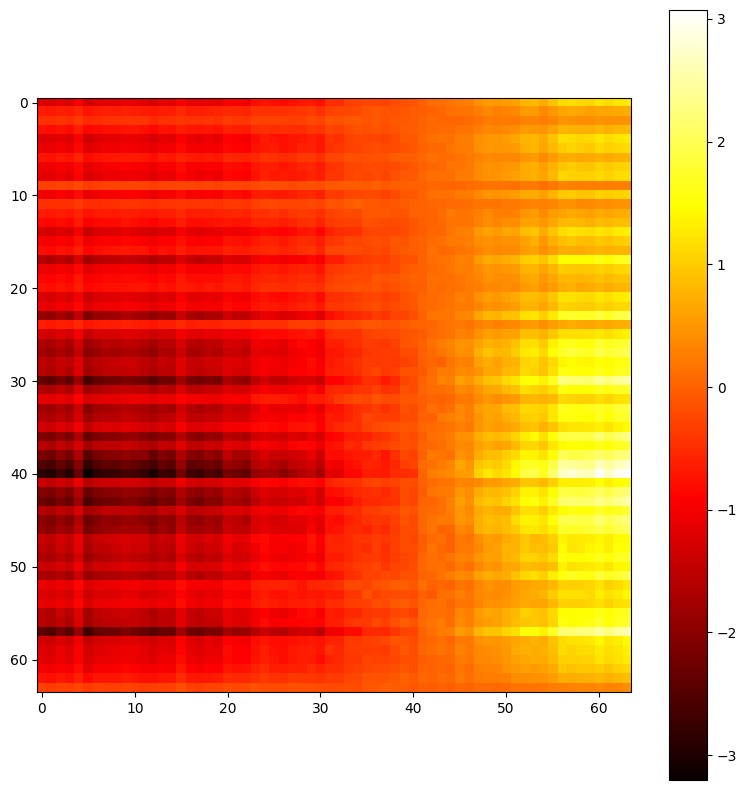

In [ ]:
plot_qk_heatmap(model_6t_no_pos)

## Subsequence Accuracy

Without the positional embedding the model can not tell which token is the last one. Hence, it learns to take the maximum of every subsequence.

In [ ]:
tokens = next(large_data_gen())
logits, cache = model_6t_no_pos.run_with_cache(tokens)

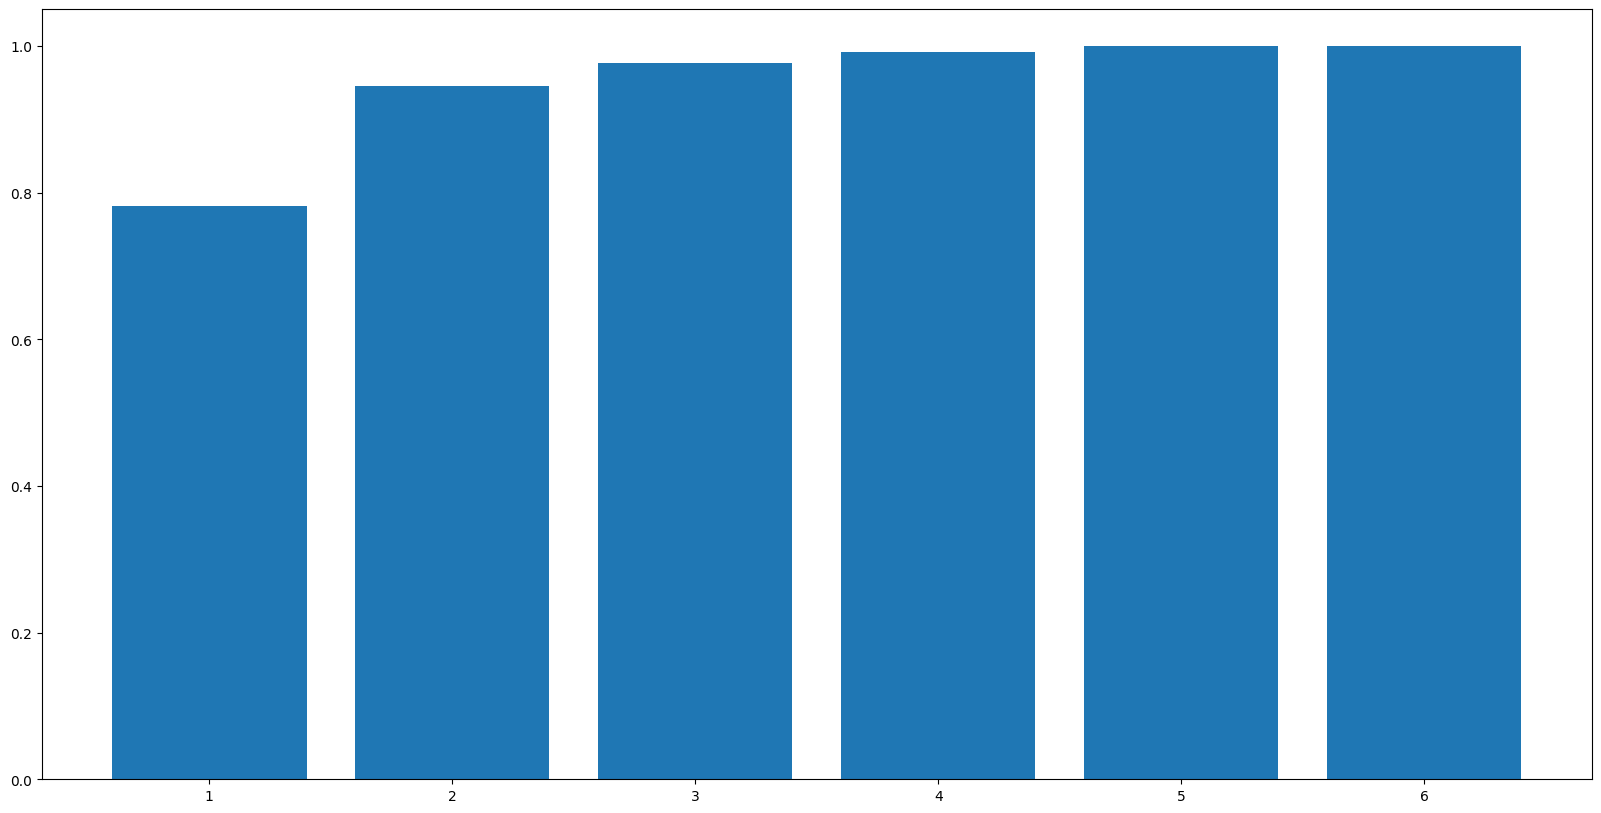

In [ ]:
ss_accuracies = [subsequence_accuracy(logits, tokens, i) for i in range(6)]
plt.bar(list(range(1,7)), ss_accuracies, align='center')
plt.show()